In [73]:
import pandas as pd

from mlforecast import MLForecast
from statsforecast import StatsForecast
from sklearn.linear_model import LinearRegression
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM, LSTM
from neuralforecast.losses.pytorch import MQLoss, RMSE
import matplotlib.pyplot as plt

from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive
)

def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

In [163]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

dfx = df.groupby(['country_cd', 'yyyymm'])[['sales_unit','f2f_calls', 'remote_calls','ae_sent','evnt_invited']].sum().reset_index()
static_df = df.pivot_table(values='total_hcp_cnt', index=['country_cd'], columns='cstmr_1_id', aggfunc='sum', fill_value=0).sum(axis=1).reset_index(name='total_hcp_cnt')
static_df.rename(columns={'country_cd': 'unique_id', 'yyyymm': 'ds'}, inplace=True)

df_nixtla = dfx[['country_cd', 'yyyymm', 'sales_unit','f2f_calls', 'remote_calls','ae_sent','evnt_invited']]
df_nixtla.rename(columns={'country_cd': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

futr_df = df_nixtla[['unique_id', 'ds', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited']]

In [188]:
# lstm search spacce:

horizon=6

config_lstm = dict(
    input_size=tune.choice([horizon*1, horizon*2]),              # Length of input window
    encoder_hidden_size=tune.randint(100, 300),            # Hidden size of LSTM cells
    encoder_n_layers=tune.randint(2,5),                   # Number of layers in LSTM
    encoder_dropout=tune.loguniform(0.01, 0.7),
    decoder_hidden_size=tune.randint(100, 300),  # size of hidden layer for the MLP decoder.
    decoder_layers=tune.randint(2, 5),   # number of layers for the MLP decoder
    learning_rate=tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    scaler_type=tune.choice(['robust', 'standard']),                   # Scaler type
    max_steps=tune.randint(20, 500),                    # Max number of training iterations
    batch_size=tune.choice([16, 32, 64, 128]),                        # Number of series in batch
    num_lr_decays=tune.loguniform(0.01, .2),
    # random_seed= tune.randint(1, 20),                       # Random seed
    hist_exog_list=['f2f_calls', 'remote_calls','ae_sent','evnt_invited'],
    futr_exog_list = ['f2f_calls', 'remote_calls','ae_sent','evnt_invited'],
    stat_exog_list = ['total_hcp_cnt']
)

model = [AutoLSTM(h=horizon,
                  config=config_lstm, 
                  #futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                  #hist_exog_list = ['total_calls'], # <- Historical exogenous variables
                  #stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                  loss=MQLoss(), #RMSE(),
                  num_samples=50, # number of configurations explored --> ideally above 25,
                  search_alg=HyperOptSearch())
         ]

In [189]:
df_nixtla2 = df_nixtla[df_nixtla.ds<='2022-05-01'].copy()

nf = NeuralForecast(
     models=model,
     freq='MS')

val_size  = 18 # 3 x 6 months
test_size = 6 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla2,
                               static_df=static_df,
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 75.70it/s, v_num=0, train_loss_step=0.119, train_loss_epoch=0.121]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=20096) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.84it/s]
(_train_tune pid=20096) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 105.99it/s, v_num=0, train_loss_step=0.0661, train_loss_epoch=0.0603, valid_loss=4.45e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 258:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0415, train_loss_epoch=0.0415, valid_loss=5.38e+3]        


2023-10-31 14:45:10,700	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 277:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0374, train_loss_epoch=0.0374, valid_loss=5.38e+3]        


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 85.59it/s, v_num=0, train_loss_step=0.0259, train_loss_epoch=0.0227]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 67.44it/s, v_num=0, train_loss_step=0.00963, train_loss_epoch=0.0115, valid_loss=6.18e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 61.44it/s, v_num=0, train_loss_step=0.0192, train_loss_epoch=0.0126, valid_loss=6.14e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 86.04it/s, v_num=0, train_loss_step=0.0147, train_loss_epoch=0.0177, valid_loss=6.08e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 434:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0132, train_loss_epoch=0.0132, valid_loss=6.19e+3]        


2023-10-31 14:45:17,538	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 452:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00702, train_loss_epoch=0.00702, valid_loss=6.19e+3]        


(_train_tune pid=20096) Seed set to 1


Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0529, train_loss_epoch=0.0529]        


2023-10-31 14:45:18,797	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 59.70it/s, v_num=0, train_loss_step=0.0471, train_loss_epoch=0.0465]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 114.79it/s, v_num=0, train_loss_step=0.0228, train_loss_epoch=0.0167]
(_train_tune pid=20096) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.27it/s]
(_train_tune pid=20096) 
Epoch 116:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0332, train_loss_epoch=0.0332, valid_loss=5.74e+3]         


2023-10-31 14:45:20,154	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 75.99it/s, v_num=0, train_loss_step=0.123, train_loss_epoch=0.151]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 59.55it/s, v_num=0, train_loss_step=0.0821, train_loss_epoch=0.107, valid_loss=4.87e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 49.34it/s, v_num=0, train_loss_step=0.0799, train_loss_epoch=0.0825, valid_loss=4.95e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 392:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0503, train_loss_epoch=0.0503, valid_loss=5.07e+3]        


2023-10-31 14:45:26,998	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 73.71it/s, v_num=0, train_loss_step=0.0637, train_loss_epoch=0.0617, valid_loss=5.07e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 407: 100%|██████████| 1/1 [00:00<00:00, 65.58it/s, v_num=0, train_loss_step=0.0632, train_loss_epoch=0.0632, valid_loss=5.23e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 101.59it/s, v_num=0, train_loss_step=0.108, train_loss_epoch=0.113]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 101.00it/s, v_num=0, train_loss_step=0.0583, train_loss_epoch=0.0363, valid_loss=5.19e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 98.93it/s, v_num=0, train_loss_step=0.0149, train_loss_epoch=0.0163, valid_loss=5.98e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 381:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0234, train_loss_epoch=0.0234, valid_loss=6.01e+3]           


2023-10-31 14:45:31,601	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 393: 100%|██████████| 1/1 [00:00<00:00, 88.98it/s, v_num=0, train_loss_step=0.0139, train_loss_epoch=0.0139, valid_loss=6.01e+3] 


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 67.03it/s, v_num=0, train_loss_step=0.0208, train_loss_epoch=0.0201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 82.64it/s, v_num=0, train_loss_step=0.0155, train_loss_epoch=0.0137, valid_loss=6.09e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 297:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.010, train_loss_epoch=0.010, valid_loss=6.34e+3]          


2023-10-31 14:45:36,567	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 81.66it/s, v_num=0, train_loss_step=0.0146, train_loss_epoch=0.0131, valid_loss=6.34e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 312:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0102, train_loss_epoch=0.0102, valid_loss=6.41e+3]        


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 112.17it/s, v_num=0, train_loss_step=0.0263, train_loss_epoch=0.0322]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 96.96it/s, v_num=0, train_loss_step=0.0219, train_loss_epoch=0.0193, valid_loss=5.75e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s, v_num=0, train_loss_step=0.0106, train_loss_epoch=0.0113, valid_loss=5.61e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 378:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0106, train_loss_epoch=0.0106, valid_loss=5.9e+3]          


2023-10-31 14:45:41,046	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 394: 100%|██████████| 1/1 [00:00<00:00, 95.95it/s, v_num=0, train_loss_step=0.012, train_loss_epoch=0.012, valid_loss=5.9e+3]   


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 88.74it/s, v_num=0, train_loss_step=0.0119, train_loss_epoch=0.0113]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 172:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00829, train_loss_epoch=0.00829, valid_loss=5.96e+3]        


2023-10-31 14:45:43,924	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 188:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00858, train_loss_epoch=0.00858, valid_loss=5.96e+3]        


(_train_tune pid=20096) Seed set to 1


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.909, train_loss_epoch=0.909]        


2023-10-31 14:45:44,362	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 110.43it/s, v_num=0, train_loss_step=0.899, train_loss_epoch=0.733]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 40.72it/s, v_num=0, train_loss_step=0.899, train_loss_epoch=0.899, valid_loss=5.91e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.68it/s, v_num=0, train_loss_step=0.0548, train_loss_epoch=0.0567]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 94.52it/s, v_num=0, train_loss_step=0.0154, train_loss_epoch=0.0143, valid_loss=5.52e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 89.61it/s, v_num=0, train_loss_step=0.00643, train_loss_epoch=0.00666, valid_loss=6.05e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 93.20it/s, v_num=0, train_loss_step=0.0061, train_loss_epoch=0.00918, valid_loss=6.17e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 428:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0204, train_loss_epoch=0.0204, valid_loss=6.15e+3]        


2023-10-31 14:45:50,020	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 448: 100%|██████████| 1/1 [00:00<00:00, 84.16it/s, v_num=0, train_loss_step=0.00952, train_loss_epoch=0.00952, valid_loss=6.15e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 84.80it/s, v_num=0, train_loss_step=0.0999, train_loss_epoch=0.124]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 86.49it/s, v_num=0, train_loss_step=0.0526, train_loss_epoch=0.0449, valid_loss=4.31e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 233:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0297, train_loss_epoch=0.0297, valid_loss=5.04e+3]        


2023-10-31 14:45:53,437	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 101.90it/s, v_num=0, train_loss_step=0.0321, train_loss_epoch=0.0501]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 159:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0187, train_loss_epoch=0.0187, valid_loss=5.87e+3]         


2023-10-31 14:45:55,381	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 96.14it/s, v_num=0, train_loss_step=0.503, train_loss_epoch=0.527]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 98.27it/s, v_num=0, train_loss_step=0.201, train_loss_epoch=0.201, valid_loss=4.92e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 206:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.192, train_loss_epoch=0.192, valid_loss=4.92e+3]         


2023-10-31 14:45:57,827	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 95.76it/s, v_num=0, train_loss_step=0.168, train_loss_epoch=0.223]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.16it/s]
(_train_tune pid=20096) 
Epoch 133:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.112, train_loss_epoch=0.112, valid_loss=5.56e+3]        


2023-10-31 14:45:59,696	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 84.45it/s, v_num=0, train_loss_step=0.147, train_loss_epoch=0.147, valid_loss=5.56e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 125.07it/s, v_num=0, train_loss_step=0.339, train_loss_epoch=0.339]


2023-10-31 14:46:00,091	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 121.85it/s, v_num=0, train_loss_step=0.256, train_loss_epoch=0.311]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.90it/s]
                                                                       
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 61.90it/s, v_num=0, train_loss_step=0.0155, train_loss_epoch=0.0167]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 73.26it/s, v_num=0, train_loss_step=0.0078, train_loss_epoch=0.00395, valid_loss=6.11e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 263:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00619, train_loss_epoch=0.00619, valid_loss=6.23e+3]        


2023-10-31 14:46:04,814	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 276:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00355, train_loss_epoch=0.00355, valid_loss=6.23e+3]        


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 97.70it/s, v_num=0, train_loss_step=0.0607, train_loss_epoch=0.0652]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.61it/s]
                                                                       
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 85.46it/s, v_num=0, train_loss_step=0.0187, train_loss_epoch=0.0151, valid_loss=5.68e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 85.71it/s, v_num=0, train_loss_step=0.00835, train_loss_epoch=0.00799, valid_loss=6.09e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 398:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00911, train_loss_epoch=0.00911, valid_loss=6.27e+3]         


2023-10-31 14:46:10,015	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 97.40it/s, v_num=0, train_loss_step=0.00847, train_loss_epoch=0.0136, valid_loss=6.27e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 417: 100%|██████████| 1/1 [00:00<00:00, 85.75it/s, v_num=0, train_loss_step=0.0112, train_loss_epoch=0.0112, valid_loss=6.18e+3]   


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 124.47it/s, v_num=0, train_loss_step=0.0206, train_loss_epoch=0.0278]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 175:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0111, train_loss_epoch=0.0111, valid_loss=6e+3]         


2023-10-31 14:46:12,004	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 116.77it/s, v_num=0, train_loss_step=0.461, train_loss_epoch=0.461]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 90.36it/s, v_num=0, train_loss_step=0.0115, train_loss_epoch=0.0156]
(_train_tune pid=20096) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 176:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00451, train_loss_epoch=0.00451, valid_loss=5.51e+3]         


2023-10-31 14:46:13,971	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 110.00it/s, v_num=0, train_loss_step=0.00609, train_loss_epoch=0.00609, valid_loss=5.51e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0392, train_loss_epoch=0.0392]         


2023-10-31 14:46:15,279	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s, v_num=0, train_loss_step=0.0321, train_loss_epoch=0.0366]
(_train_tune pid=20096) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.26it/s]
(_train_tune pid=20096) 
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.885, train_loss_epoch=0.885]        


(_train_tune pid=20096) Seed set to 1
2023-10-31 14:46:15,627	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 106.38it/s, v_num=0, train_loss_step=0.691, train_loss_epoch=0.713]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 41.31it/s, v_num=0, train_loss_step=0.691, train_loss_epoch=0.691, valid_loss=5.79e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 104.71it/s, v_num=0, train_loss_step=0.0259, train_loss_epoch=0.0239]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.41it/s]
                                                                       
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 94.71it/s, v_num=0, train_loss_step=0.0158, train_loss_epoch=0.00934, valid_loss=6.67e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 106.53it/s, v_num=0, train_loss_step=0.00816, train_loss_epoch=0.0102, valid_loss=6.56e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 314:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00857, train_loss_epoch=0.00857, valid_loss=6.67e+3]        


2023-10-31 14:46:19,316	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.806, train_loss_epoch=0.806]         


(_train_tune pid=20096) Seed set to 1


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.332, train_loss_epoch=0.332]         


2023-10-31 14:46:20,186	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 104.19it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.227]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 40.14it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.213, valid_loss=4.39e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 113.86it/s, v_num=0, train_loss_step=0.149, train_loss_epoch=0.151]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 113.23it/s, v_num=0, train_loss_step=0.0786, train_loss_epoch=0.0611, valid_loss=5.48e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 228:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0442, train_loss_epoch=0.0442, valid_loss=6431.5]         


2023-10-31 14:46:22,729	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.799, train_loss_epoch=0.799]         


(_train_tune pid=20096) Seed set to 1


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.670, train_loss_epoch=0.670]        


2023-10-31 14:46:23,399	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 121.14it/s, v_num=0, train_loss_step=0.299, train_loss_epoch=0.383]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 43.43it/s, v_num=0, train_loss_step=0.299, train_loss_epoch=0.299, valid_loss=4.2e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0369, train_loss_epoch=0.0369]        


2023-10-31 14:46:24,627	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 88.62it/s, v_num=0, train_loss_step=0.0248, train_loss_epoch=0.0279] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.804, train_loss_epoch=0.804]         


2023-10-31 14:46:25,568	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 115.03it/s, v_num=0, train_loss_step=0.559, train_loss_epoch=0.567]
Validation: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 107.04it/s, v_num=0, train_loss_step=0.133, train_loss_epoch=0.133]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.36it/s]
                                                                       
Epoch 112:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.122, train_loss_epoch=0.122, valid_loss=5.24e+3]         


2023-10-31 14:46:27,391	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 93.92it/s, v_num=0, train_loss_step=0.0999, train_loss_epoch=0.0999, valid_loss=5.24e+3] 


(_train_tune pid=20096) Seed set to 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 117.83it/s, v_num=0, train_loss_step=0.357, train_loss_epoch=0.357]


2023-10-31 14:46:28,123	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 108.59it/s, v_num=0, train_loss_step=0.232, train_loss_epoch=0.287]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s, v_num=0, train_loss_step=0.232, train_loss_epoch=0.232, valid_loss=4.41e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0189, train_loss_epoch=0.0189]        


2023-10-31 14:46:30,098	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 93.92it/s, v_num=0, train_loss_step=0.0222, train_loss_epoch=0.0189]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 120:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0164, train_loss_epoch=0.0164, valid_loss=6.52e+3]        


(_train_tune pid=20096) Seed set to 1


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.749, train_loss_epoch=0.749]        


2023-10-31 14:46:30,469	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 97.94it/s, v_num=0, train_loss_step=0.681, train_loss_epoch=0.700] 
Validation: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 108.95it/s, v_num=0, train_loss_step=0.100, train_loss_epoch=0.0982] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, v_num=0, train_loss_step=0.0391, train_loss_epoch=0.0257, valid_loss=5.78e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 108.92it/s, v_num=0, train_loss_step=0.00951, train_loss_epoch=0.0116, valid_loss=6.21e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 312:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00861, train_loss_epoch=0.00861, valid_loss=6.18e+3]         


2023-10-31 14:46:38,062	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 330:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00723, train_loss_epoch=0.00723, valid_loss=6.18e+3]         


(_train_tune pid=20096) Seed set to 1


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.091, train_loss_epoch=0.091]         


2023-10-31 14:46:40,016	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 118.27it/s, v_num=0, train_loss_step=0.0638, train_loss_epoch=0.0645]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 43.39it/s, v_num=0, train_loss_step=0.0638, train_loss_epoch=0.0638, valid_loss=6.64e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.103, train_loss_epoch=0.103]         


2023-10-31 14:46:41,329	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 98.44it/s, v_num=0, train_loss_step=0.120, train_loss_epoch=0.123] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 112.18it/s, v_num=0, train_loss_step=0.0383, train_loss_epoch=0.0414]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 108.23it/s, v_num=0, train_loss_step=0.0208, train_loss_epoch=0.0161, valid_loss=6.14e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 110.35it/s, v_num=0, train_loss_step=0.0118, train_loss_epoch=0.0119, valid_loss=6.01e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 74.05it/s, v_num=0, train_loss_step=0.00578, train_loss_epoch=0.00692, valid_loss=6.08e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 462:   0%|          | 0/1 [00:00<?, ?i

2023-10-31 14:46:46,984	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 487: 100%|██████████| 1/1 [00:00<00:00, 98.36it/s, v_num=0, train_loss_step=0.0087, train_loss_epoch=0.0087, valid_loss=6.3e+3]   


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 105.02it/s, v_num=0, train_loss_step=0.0188, train_loss_epoch=0.019] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 151:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=6.51e+3]         


2023-10-31 14:46:49,313	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 99.82it/s, v_num=0, train_loss_step=0.0982, train_loss_epoch=0.101]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 76.60it/s, v_num=0, train_loss_step=0.0344, train_loss_epoch=0.0182, valid_loss=5.15e+3]
(_train_tune pid=20096) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 102.50it/s, v_num=0, train_loss_step=0.00952, train_loss_epoch=0.0125, valid_loss=5.83e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 360:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00982, train_loss_epoch=0.00982, valid_loss=6.02e+3]         


2023-10-31 14:46:54,179	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=20096) Seed set to 1


Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.221, train_loss_epoch=0.221]        


2023-10-31 14:46:55,574	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.32it/s, v_num=0, train_loss_step=0.180, train_loss_epoch=0.187]
Validation: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=20096) Seed set to 1


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.283, train_loss_epoch=0.283]         


2023-10-31 14:46:56,035	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 131.65it/s, v_num=0, train_loss_step=0.228, train_loss_epoch=0.258]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 84.71it/s, v_num=0, train_loss_step=0.0429, train_loss_epoch=0.0433]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 87.14it/s, v_num=0, train_loss_step=0.0157, train_loss_epoch=0.0103, valid_loss=5.41e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 272:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00528, train_loss_epoch=0.00528, valid_loss=5.87e+3]        


2023-10-31 14:46:59,726	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 105.09it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.276]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 126:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.213, valid_loss=5.09e+3]        


2023-10-31 14:47:01,394	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.542, train_loss_epoch=0.542]         


2023-10-31 14:47:02,399	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 110.48it/s, v_num=0, train_loss_step=0.379, train_loss_epoch=0.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.388, train_loss_epoch=0.388]         


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 105.54it/s, v_num=0, train_loss_step=0.025, train_loss_epoch=0.0223] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0185, train_loss_epoch=0.0185, valid_loss=5.77e+3]         


2023-10-31 14:47:04,983	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 102.22it/s, v_num=0, train_loss_step=0.011, train_loss_epoch=0.0185, valid_loss=5.77e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 221:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0107, train_loss_epoch=0.0107, valid_loss=5.68e+3]         


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 111.64it/s, v_num=0, train_loss_step=0.119, train_loss_epoch=0.124]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 110.98it/s, v_num=0, train_loss_step=0.054, train_loss_epoch=0.0329, valid_loss=5.48e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 113.14it/s, v_num=0, train_loss_step=0.017, train_loss_epoch=0.0149, valid_loss=6.29e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 108.89it/s, v_num=0, train_loss_step=0.0086, train_loss_epoch=0.00874, valid_loss=6.54e+3] 
(_train_tune pid=20096) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 491:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0124, train_loss

2023-10-31 14:47:10,213	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 56.55it/s, v_num=0, train_loss_step=0.218, train_loss_epoch=0.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 172:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.132, train_loss_epoch=0.132, valid_loss=4.78e+3]        


2023-10-31 14:47:13,796	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 121.57it/s, v_num=0, train_loss_step=0.00656, train_loss_epoch=0.00885]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20096) 
Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00516, train_loss_epoch=0.00516, valid_loss=5.51e+3]         


2023-10-31 14:47:15,907	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20096) Seed set to 1


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 121.89it/s, v_num=0, train_loss_step=0.00754, train_loss_epoch=0.00516, valid_loss=5.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 80.85it/s, v_num=0, train_loss_step=0.215, train_loss_epoch=0.285]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 128:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.181, valid_loss=4.87e+3]        


2023-10-31 14:47:17,919	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 150:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.152, train_loss_epoch=0.152, valid_loss=4.87e+3]        


(_train_tune pid=20096) Seed set to 1


Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0836, train_loss_epoch=0.0836]         


2023-10-31 14:47:19,137	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 119.71it/s, v_num=0, train_loss_step=0.0737, train_loss_epoch=0.0756]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=20096) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.33it/s]
                                                                       
Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 105.44it/s, v_num=0, train_loss_step=0.0699, train_loss_epoch=0.0699, valid_loss=5.18e+3]


(_train_tune pid=20096) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 109.29it/s, v_num=0, train_loss_step=0.109, train_loss_epoch=0.112]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 94.77it/s, v_num=0, train_loss_step=0.0506, train_loss_epoch=0.037, valid_loss=5.32e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.19it/s]
(_train_tune pid=20096) 
Epoch 281:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0135, train_loss_epoch=0.0135, valid_loss=5.62e+3]         


2023-10-31 14:47:22,544	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 1


Epoch 296: 100%|██████████| 1/1 [00:00<00:00, 93.30it/s, v_num=0, train_loss_step=0.0161, train_loss_epoch=0.0161, valid_loss=5.62e+3] 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [190]:
nf.models[0].results.get_best_result().config

{'input_size': 12,
 'encoder_hidden_size': 128,
 'encoder_n_layers': 2,
 'encoder_dropout': 0.05886265561818178,
 'decoder_hidden_size': 126,
 'decoder_layers': 4,
 'learning_rate': 0.0002828828009198774,
 'scaler_type': 'robust',
 'max_steps': 52,
 'batch_size': 64,
 'num_lr_decays': 0.037815201774331834,
 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'),
 'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'),
 'stat_exog_list': ('total_hcp_cnt',),
 'h': 6,
 'loss': MQLoss(),
 'valid_loss': MQLoss()}

In [191]:
nf.fit(df=df_nixtla2,
       static_df=static_df)

(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 105.66it/s, v_num=0, train_loss_step=0.136, train_loss_epoch=0.204]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 105.90it/s, v_num=0, train_loss_step=0.0906, train_loss_epoch=0.107, valid_loss=2.85e+3]
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.78it/s]
(_train_tune pid=6950) 
Epoch 280:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0735, train_loss_epoch=0.0735, valid_loss=2.62e+3]         


2023-10-31 14:47:32,380	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 85.72it/s, v_num=0, train_loss_step=0.114, train_loss_epoch=0.0566] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 85.36it/s, v_num=0, train_loss_step=0.0323, train_loss_epoch=0.0197, valid_loss=1.22e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 66.45it/s, v_num=0, train_loss_step=0.0116, train_loss_epoch=0.0191, valid_loss=1.74e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 62.54it/s, v_num=0, train_loss_step=0.0165, train_loss_epoch=0.019, valid_loss=2.02e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 442:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0199, train_loss_epoch=0.0199, valid_loss=1.66e+3]        


2023-10-31 14:47:39,244	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 452: 100%|██████████| 1/1 [00:00<00:00, 74.73it/s, v_num=0, train_loss_step=0.0144, train_loss_epoch=0.0144, valid_loss=1.66e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.155, train_loss_epoch=0.155]          


2023-10-31 14:47:40,355	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.120, train_loss_epoch=0.120]        


(_train_tune pid=6950) Seed set to 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 84.44it/s, v_num=0, train_loss_step=0.108, train_loss_epoch=0.112]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0383, train_loss_epoch=0.0383]        


2023-10-31 14:47:41,757	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 115.63it/s, v_num=0, train_loss_step=0.0693, train_loss_epoch=0.0371]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 100.45it/s, v_num=0, train_loss_step=0.0717, train_loss_epoch=0.0717, valid_loss=3.03e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 74.57it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.224]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 77.56it/s, v_num=0, train_loss_step=0.137, train_loss_epoch=0.115, valid_loss=2.46e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 74.07it/s, v_num=0, train_loss_step=0.137, train_loss_epoch=0.150, valid_loss=2.93e+3]
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 396:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.092, train_loss_epoch=0.092, valid_loss=2.49e+3]        


2023-10-31 14:47:48,251	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 63.96it/s, v_num=0, train_loss_step=0.0753, train_loss_epoch=0.0962, valid_loss=2.49e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 407: 100%|██████████| 1/1 [00:00<00:00, 68.53it/s, v_num=0, train_loss_step=0.0719, train_loss_epoch=0.0719, valid_loss=2.1e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 100.87it/s, v_num=0, train_loss_step=0.128, train_loss_epoch=0.218]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s, v_num=0, train_loss_step=0.0715, train_loss_epoch=0.0922, valid_loss=2.09e+3]
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 100.01it/s, v_num=0, train_loss_step=0.0513, train_loss_epoch=0.0665, valid_loss=2.44e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 386:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.041, train_loss_epoch=0.041, valid_loss=2.04e+3]           


2023-10-31 14:47:52,834	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 80.96it/s, v_num=0, train_loss_step=0.0771, train_loss_epoch=0.0807]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 82.13it/s, v_num=0, train_loss_step=0.0335, train_loss_epoch=0.0285, valid_loss=1.35e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 295:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.031, train_loss_epoch=0.031, valid_loss=2.43e+3]          


2023-10-31 14:47:57,434	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 80.43it/s, v_num=0, train_loss_step=0.0133, train_loss_epoch=0.015, valid_loss=2.43e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 313:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0127, train_loss_epoch=0.0127, valid_loss=2.38e+3]        


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 108.35it/s, v_num=0, train_loss_step=0.0736, train_loss_epoch=0.108] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 106.61it/s, v_num=0, train_loss_step=0.0333, train_loss_epoch=0.0328, valid_loss=2.44e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 109.95it/s, v_num=0, train_loss_step=0.0223, train_loss_epoch=0.0291, valid_loss=2.37e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 384:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0393, train_loss_epoch=0.0393, valid_loss=2.22e+3]        


2023-10-31 14:48:01,869	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 394: 100%|██████████| 1/1 [00:00<00:00, 86.57it/s, v_num=0, train_loss_step=0.0177, train_loss_epoch=0.0177, valid_loss=2.22e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 83.88it/s, v_num=0, train_loss_step=0.0406, train_loss_epoch=0.0677]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 176:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0199, train_loss_epoch=0.0199, valid_loss=2.32e+3]        


2023-10-31 14:48:04,570	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 188: 100%|██████████| 1/1 [00:00<00:00, 77.41it/s, v_num=0, train_loss_step=0.0299, train_loss_epoch=0.0299, valid_loss=2.32e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.421, train_loss_epoch=0.421]         


2023-10-31 14:48:04,978	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 123.87it/s, v_num=0, train_loss_step=0.255, train_loss_epoch=0.265]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 91.83it/s, v_num=0, train_loss_step=0.145, train_loss_epoch=0.0879] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 81.77it/s, v_num=0, train_loss_step=0.0687, train_loss_epoch=0.0408, valid_loss=2.2e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 92.15it/s, v_num=0, train_loss_step=0.0324, train_loss_epoch=0.0353, valid_loss=2.08e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 93.04it/s, v_num=0, train_loss_step=0.0174, train_loss_epoch=0.0203, valid_loss=2.08e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 429:   0%|          | 0/1 [00:0

2023-10-31 14:48:10,817	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 448: 100%|██████████| 1/1 [00:00<00:00, 82.34it/s, v_num=0, train_loss_step=0.0329, train_loss_epoch=0.0329, valid_loss=2.12e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 85.68it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.186]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 81.93it/s, v_num=0, train_loss_step=0.122, train_loss_epoch=0.102, valid_loss=2.54e+3]
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.51it/s]
(_train_tune pid=6950) 
Epoch 220:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.107, train_loss_epoch=0.107, valid_loss=2.57e+3]          


2023-10-31 14:48:14,208	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 241:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0951, train_loss_epoch=0.0951, valid_loss=2.57e+3]        


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 117.42it/s, v_num=0, train_loss_step=0.0989, train_loss_epoch=0.0643]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 143:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0555, train_loss_epoch=0.0555, valid_loss=2.21e+3]         


2023-10-31 14:48:16,042	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 102.14it/s, v_num=0, train_loss_step=0.0626, train_loss_epoch=0.0626, valid_loss=2.21e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 98.66it/s, v_num=0, train_loss_step=0.235, train_loss_epoch=0.471] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 192:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.200, train_loss_epoch=0.200, valid_loss=2.83e+3]         


2023-10-31 14:48:19,209	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 109.04it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.253, valid_loss=2.83e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 214:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.195, train_loss_epoch=0.195, valid_loss=2.82e+3]         


(_train_tune pid=6950) Seed set to 1


Epoch 216: 100%|██████████| 1/1 [00:00<00:00, 93.05it/s, v_num=0, train_loss_step=0.192, train_loss_epoch=0.192, valid_loss=2.82e+3] 
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 93.81it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.263]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 121:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.190, train_loss_epoch=0.190, valid_loss=3.25e+3]        


2023-10-31 14:48:21,103	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 143:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.200, train_loss_epoch=0.200, valid_loss=3.25e+3]        


(_train_tune pid=6950) Seed set to 1


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.208, train_loss_epoch=0.208]         


2023-10-31 14:48:21,644	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 122.60it/s, v_num=0, train_loss_step=0.210, train_loss_epoch=0.222]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.23it/s]
                                                                       
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 70.05it/s, v_num=0, train_loss_step=0.0683, train_loss_epoch=0.079] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 69.90it/s, v_num=0, train_loss_step=0.0232, train_loss_epoch=0.0262, valid_loss=1.62e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 266:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0175, train_loss_epoch=0.0175, valid_loss=1.88e+3]        


2023-10-31 14:48:26,260	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 276: 100%|██████████| 1/1 [00:00<00:00, 63.46it/s, v_num=0, train_loss_step=0.0175, train_loss_epoch=0.0175, valid_loss=1.88e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 97.43it/s, v_num=0, train_loss_step=0.154, train_loss_epoch=0.112]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 79.92it/s, v_num=0, train_loss_step=0.0894, train_loss_epoch=0.0565, valid_loss=2.14e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, v_num=0, train_loss_step=0.0473, train_loss_epoch=0.0512, valid_loss=2.16e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 96.86it/s, v_num=0, train_loss_step=0.0274, train_loss_epoch=0.0311, valid_loss=1.93e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 412:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0153, train_loss_epoch=0.0153, valid_loss=1.96e+3]        


2023-10-31 14:48:31,727	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 108.34it/s, v_num=0, train_loss_step=0.164, train_loss_epoch=0.0778] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 171:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0688, train_loss_epoch=0.0688, valid_loss=2.34e+3]         


2023-10-31 14:48:35,481	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 194: 100%|██████████| 1/1 [00:00<00:00, 101.89it/s, v_num=0, train_loss_step=0.0386, train_loss_epoch=0.0386, valid_loss=2.34e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 114.12it/s, v_num=0, train_loss_step=0.119, train_loss_epoch=0.0518] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 179:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0224, train_loss_epoch=0.0224, valid_loss=2.14e+3]         


2023-10-31 14:48:40,648	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.11it/s, v_num=0, train_loss_step=0.0639, train_loss_epoch=0.0452]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 55.09it/s, v_num=0, train_loss_step=0.0255, train_loss_epoch=0.0482, valid_loss=2.18e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 62.91it/s, v_num=0, train_loss_step=0.0127, train_loss_epoch=0.0142, valid_loss=1.4e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.45it/s]
(_train_tune pid=6950) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 65.49it/s, v_num=0, train_loss_step=0.030, train_loss_epoch=0.0356, valid_loss=2.06e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 483:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0118, train_loss_epoch=0.0118, valid_loss=1.87e+3]          


2023-10-31 14:48:51,021	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 77.93it/s, v_num=0, train_loss_step=0.0736, train_loss_epoch=0.050] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 86.26it/s, v_num=0, train_loss_step=0.0152, train_loss_epoch=0.0197, valid_loss=2.56e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 75.70it/s, v_num=0, train_loss_step=0.0142, train_loss_epoch=0.0137, valid_loss=2.17e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 333:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0355, train_loss_epoch=0.0355, valid_loss=1.92e+3]        


2023-10-31 14:48:56,235	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 70.05it/s, v_num=0, train_loss_step=0.0374, train_loss_epoch=0.0727]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 72.00it/s, v_num=0, train_loss_step=0.0309, train_loss_epoch=0.0423, valid_loss=1.72e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 70.54it/s, v_num=0, train_loss_step=0.0107, train_loss_epoch=0.0104, valid_loss=1.9e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.94it/s]
                                                                       
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 62.15it/s, v_num=0, train_loss_step=0.00492, train_loss_epoch=0.00533, valid_loss=2.08e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 494:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_l

2023-10-31 14:49:04,495	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 93.96it/s, v_num=0, train_loss_step=0.0323, train_loss_epoch=0.0473]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 94.07it/s, v_num=0, train_loss_step=0.027, train_loss_epoch=0.0254, valid_loss=1.18e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 90.44it/s, v_num=0, train_loss_step=0.0117, train_loss_epoch=0.0248, valid_loss=1.82e+3]
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 93.07it/s, v_num=0, train_loss_step=0.0207, train_loss_epoch=0.0249, valid_loss=2.1e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 451:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0208, train_loss_epoch=0.0208, valid_loss=1.94e+3]        


2023-10-31 14:49:10,466	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 463: 100%|██████████| 1/1 [00:00<00:00, 82.70it/s, v_num=0, train_loss_step=0.0178, train_loss_epoch=0.0178, valid_loss=1.94e+3]  


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 79.79it/s, v_num=0, train_loss_step=0.0868, train_loss_epoch=0.0527]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 78.40it/s, v_num=0, train_loss_step=0.0434, train_loss_epoch=0.0244, valid_loss=1.46e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 66.86it/s, v_num=0, train_loss_step=0.0467, train_loss_epoch=0.0457, valid_loss=1.27e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 78.26it/s, v_num=0, train_loss_step=0.0127, train_loss_epoch=0.0152, valid_loss=994.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 483:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0221, train_loss_epoch=0.0221, valid_loss=1.71e+3]        


2023-10-31 14:49:18,268	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 495: 100%|██████████| 1/1 [00:00<00:00, 70.30it/s, v_num=0, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=1.71e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 86.53it/s, v_num=0, train_loss_step=0.0362, train_loss_epoch=0.0483]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 83.86it/s, v_num=0, train_loss_step=0.027, train_loss_epoch=0.0329, valid_loss=2.08e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 87.25it/s, v_num=0, train_loss_step=0.00809, train_loss_epoch=0.0166, valid_loss=1.56e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 76.27it/s, v_num=0, train_loss_step=0.0155, train_loss_epoch=0.0119, valid_loss=2.08e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 455:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0177, train_loss_epoch=0.0177, valid_loss=1.93e+3]        


2023-10-31 14:49:24,787	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 77.43it/s, v_num=0, train_loss_step=0.101, train_loss_epoch=0.0479] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.92it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 79.55it/s, v_num=0, train_loss_step=0.0314, train_loss_epoch=0.0132, valid_loss=1.66e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 68.26it/s, v_num=0, train_loss_step=0.0116, train_loss_epoch=0.0176, valid_loss=1.53e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 353:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.012, train_loss_epoch=0.012, valid_loss=1.87e+3]          


2023-10-31 14:49:30,224	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 87.16it/s, v_num=0, train_loss_step=0.149, train_loss_epoch=0.125]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 94.23it/s, v_num=0, train_loss_step=0.0849, train_loss_epoch=0.0553, valid_loss=2.08e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 96.49it/s, v_num=0, train_loss_step=0.0299, train_loss_epoch=0.0317, valid_loss=2.17e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 97.34it/s, v_num=0, train_loss_step=0.0162, train_loss_epoch=0.0138, valid_loss=1.83e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 478:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0126, train_loss_epoch=0.0126, valid_loss=1.94e+3]        


2023-10-31 14:49:36,490	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 497:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=1.94e+3]        


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s, v_num=0, train_loss_step=0.116, train_loss_epoch=0.0361] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 89.12it/s, v_num=0, train_loss_step=0.0238, train_loss_epoch=0.0179, valid_loss=1.43e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=6950) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.52it/s]
(_train_tune pid=6950) 
Epoch 284:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0141, train_loss_epoch=0.0141, valid_loss=2.03e+3]        


2023-10-31 14:49:40,495	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 92.16it/s, v_num=0, train_loss_step=0.0146, train_loss_epoch=0.0207, valid_loss=2.03e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 303: 100%|██████████| 1/1 [00:00<00:00, 79.12it/s, v_num=0, train_loss_step=0.0574, train_loss_epoch=0.0574, valid_loss=1.7e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 55.66it/s, v_num=0, train_loss_step=0.194, train_loss_epoch=0.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 62.88it/s, v_num=0, train_loss_step=0.202, train_loss_epoch=0.0917, valid_loss=2.77e+3] 
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 72.05it/s, v_num=0, train_loss_step=0.0695, train_loss_epoch=0.0816, valid_loss=2.53e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 70.72it/s, v_num=0, train_loss_step=0.0635, train_loss_epoch=0.0646, valid_loss=1.96e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 423:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0622, train_loss_epoch=0.0622, valid_loss=1.86e+3]        


2023-10-31 14:49:48,241	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 435: 100%|██████████| 1/1 [00:00<00:00, 55.63it/s, v_num=0, train_loss_step=0.0655, train_loss_epoch=0.0655, valid_loss=1.86e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 72.18it/s, v_num=0, train_loss_step=0.0502, train_loss_epoch=0.0382]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 87.72it/s, v_num=0, train_loss_step=0.0271, train_loss_epoch=0.0439, valid_loss=2.3e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 71.37it/s, v_num=0, train_loss_step=0.0441, train_loss_epoch=0.0386, valid_loss=2.13e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 300:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0441, train_loss_epoch=0.0441, valid_loss=928.0]          


2023-10-31 14:49:52,997	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 314:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.035, train_loss_epoch=0.035, valid_loss=928.0]          


(_train_tune pid=6950) Seed set to 1


Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0453, train_loss_epoch=0.0453]        


2023-10-31 14:49:54,528	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 97.90it/s, v_num=0, train_loss_step=0.0401, train_loss_epoch=0.070]
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.97it/s]
(_train_tune pid=6950) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 88.08it/s, v_num=0, train_loss_step=0.0672, train_loss_epoch=0.0455]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 75.20it/s, v_num=0, train_loss_step=0.064, train_loss_epoch=0.0208, valid_loss=2.72e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 89.11it/s, v_num=0, train_loss_step=0.0263, train_loss_epoch=0.0367, valid_loss=1.63e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 359:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0102, train_loss_epoch=0.0102, valid_loss=1.62e+3]        


2023-10-31 14:49:59,769	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6950) Seed set to 1


Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0501, train_loss_epoch=0.0501]         


2023-10-31 14:50:01,078	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 104.73it/s, v_num=0, train_loss_step=0.066, train_loss_epoch=0.0547] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 104:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.121, train_loss_epoch=0.121, valid_loss=3.07e+3]         


(_train_tune pid=6950) Seed set to 1


Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0799, train_loss_epoch=0.0799]        


2023-10-31 14:50:02,222	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 94.53it/s, v_num=0, train_loss_step=0.0642, train_loss_epoch=0.183] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 111.18it/s, v_num=0, train_loss_step=0.109, train_loss_epoch=0.0429] 
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 113.20it/s, v_num=0, train_loss_step=0.0212, train_loss_epoch=0.0183, valid_loss=2.11e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 249:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0157, train_loss_epoch=0.0157, valid_loss=1.96e+3]         


2023-10-31 14:50:05,031	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s, v_num=0, train_loss_step=0.0668, train_loss_epoch=0.0325]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 99.99it/s, v_num=0, train_loss_step=0.0504, train_loss_epoch=0.0269, valid_loss=1.81e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 83.69it/s, v_num=0, train_loss_step=0.0333, train_loss_epoch=0.0391, valid_loss=1.93e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 308:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=1.81e+3]        


2023-10-31 14:50:09,004	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 102.36it/s, v_num=0, train_loss_step=0.195, train_loss_epoch=0.223]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 88.07it/s, v_num=0, train_loss_step=0.121, train_loss_epoch=0.0857, valid_loss=1.78e+3] 
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 218:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.108, train_loss_epoch=0.108, valid_loss=2.49e+3]        


2023-10-31 14:50:11,892	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.21it/s, v_num=0, train_loss_step=0.129, train_loss_epoch=0.059]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 105.60it/s, v_num=0, train_loss_step=0.0384, train_loss_epoch=0.0106, valid_loss=1.74e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 270:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.029, train_loss_epoch=0.029, valid_loss=1.92e+3]         


2023-10-31 14:50:15,280	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 293: 100%|██████████| 1/1 [00:00<00:00, 94.50it/s, v_num=0, train_loss_step=0.0239, train_loss_epoch=0.0239, valid_loss=1.92e+3] 


(_train_tune pid=6950) Seed set to 1


Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.091, train_loss_epoch=0.091]           


2023-10-31 14:50:16,072	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 115.52it/s, v_num=0, train_loss_step=0.137, train_loss_epoch=0.106]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 94.35it/s, v_num=0, train_loss_step=0.140, train_loss_epoch=0.105]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 66.44it/s, v_num=0, train_loss_step=0.0937, train_loss_epoch=0.0515, valid_loss=1.31e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.33it/s]
                                                                       
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 92.98it/s, v_num=0, train_loss_step=0.052, train_loss_epoch=0.0594, valid_loss=2.57e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 314:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0497, trai

2023-10-31 14:50:20,592	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 336:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0551, train_loss_epoch=0.0551, valid_loss=2.11e+3]        


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 88.36it/s, v_num=0, train_loss_step=0.109, train_loss_epoch=0.0607] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 120.97it/s, v_num=0, train_loss_step=0.0651, train_loss_epoch=0.0391, valid_loss=2.28e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 264:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0429, train_loss_epoch=0.0429, valid_loss=2.12e+3]         


2023-10-31 14:50:23,595	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 96.39it/s, v_num=0, train_loss_step=0.129, train_loss_epoch=0.111]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 115:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0842, train_loss_epoch=0.0842, valid_loss=2.57e+3]        


2023-10-31 14:50:25,817	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6950) Seed set to 1


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.126, train_loss_epoch=0.126]        


2023-10-31 14:50:26,782	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 91.18it/s, v_num=0, train_loss_step=0.0992, train_loss_epoch=0.0921]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 35.17it/s, v_num=0, train_loss_step=0.0992, train_loss_epoch=0.0992, valid_loss=2.3e+3]


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 99.39it/s, v_num=0, train_loss_step=0.112, train_loss_epoch=0.0377]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 132:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.042, train_loss_epoch=0.042, valid_loss=1.77e+3]           


2023-10-31 14:50:29,137	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 85.98it/s, v_num=0, train_loss_step=0.0375, train_loss_epoch=0.0375, valid_loss=1.77e+3] 


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 114.49it/s, v_num=0, train_loss_step=0.153, train_loss_epoch=0.104]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 101.79it/s, v_num=0, train_loss_step=0.0602, train_loss_epoch=0.0522, valid_loss=2.46e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 112.12it/s, v_num=0, train_loss_step=0.0446, train_loss_epoch=0.0606, valid_loss=2.27e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 377:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0314, train_loss_epoch=0.0314, valid_loss=2.18e+3]         


2023-10-31 14:50:35,020	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 387: 100%|██████████| 1/1 [00:00<00:00, 89.51it/s, v_num=0, train_loss_step=0.0341, train_loss_epoch=0.0341, valid_loss=2.18e+3] 


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 108.56it/s, v_num=0, train_loss_step=0.155, train_loss_epoch=0.0575] 
(_train_tune pid=6950) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6950) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 105.10it/s, v_num=0, train_loss_step=0.050, train_loss_epoch=0.0452, valid_loss=2.07e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 221:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0296, train_loss_epoch=0.0296, valid_loss=1.67e+3]        


2023-10-31 14:50:40,942	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 245:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0212, train_loss_epoch=0.0212, valid_loss=1.67e+3]        


(_train_tune pid=6950) Seed set to 1


Epoch 247: 100%|██████████| 1/1 [00:00<00:00, 86.30it/s, v_num=0, train_loss_step=0.0211, train_loss_epoch=0.0211, valid_loss=1.67e+3] 
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 101.56it/s, v_num=0, train_loss_step=0.105, train_loss_epoch=0.0405] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 91.11it/s, v_num=0, train_loss_step=0.0624, train_loss_epoch=0.0282, valid_loss=1.74e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 223:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0295, train_loss_epoch=0.0295, valid_loss=1.27e+3]        


2023-10-31 14:50:44,230	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=6950) Seed set to 1


Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0783, train_loss_epoch=0.0783]         


2023-10-31 14:50:45,722	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 125.99it/s, v_num=0, train_loss_step=0.105, train_loss_epoch=0.0785] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 43.71it/s, v_num=0, train_loss_step=0.105, train_loss_epoch=0.105, valid_loss=2.9e+3] 


(_train_tune pid=6950) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 76.22it/s, v_num=0, train_loss_step=0.117, train_loss_epoch=0.165]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 191:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0802, train_loss_epoch=0.0802, valid_loss=2.46e+3]        


2023-10-31 14:50:49,239	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0706, train_loss_epoch=0.0706, valid_loss=2.46e+3]        


Seed set to 1


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 76.34it/s, v_num=0, train_loss_step=0.0637, train_loss_epoch=0.0706, valid_loss=2.46e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 204: 100%|██████████| 1/1 [00:00<00:00, 68.99it/s, v_num=0, train_loss_step=0.0624, train_loss_epoch=0.0624, valid_loss=2.16e+3]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [192]:
# save trained model:

nf.save(path='models', model_index=None, overwrite=True)

In [193]:
# load trained model:

fcst_pre_trained = NeuralForecast.load(path='models')

Seed set to 1


Predicting: |          | 0/? [00:00<?, ?it/s]

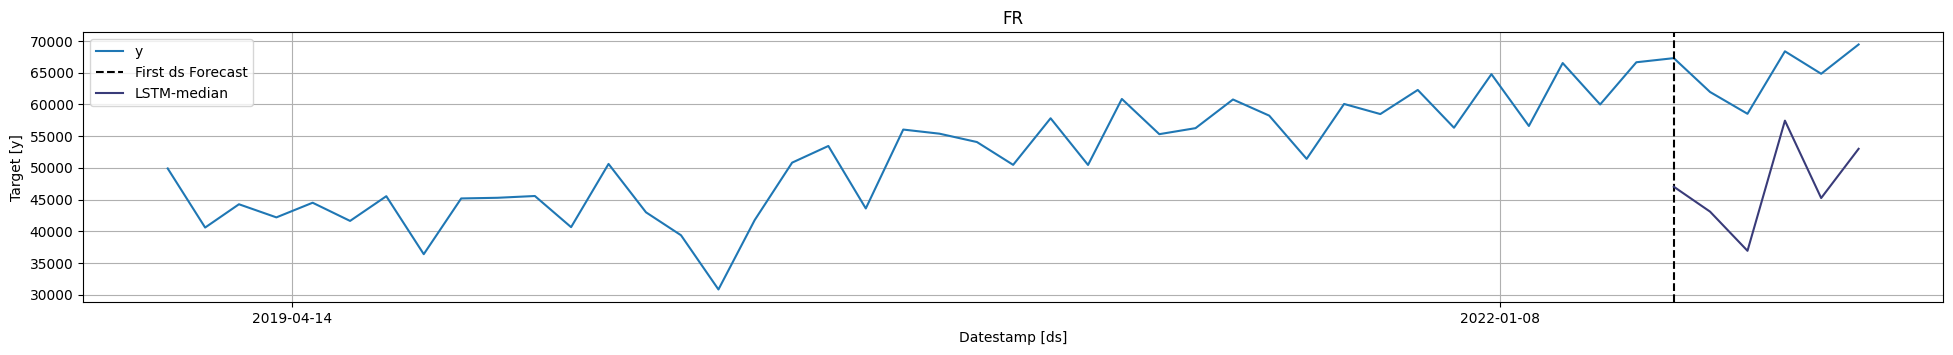

In [194]:
df_nixtla_test = df_nixtla[df_nixtla.ds<='2022-05-01'].copy()

futr_df = df_nixtla[['unique_id', 'ds', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited']]

y_hat_test = fcst_pre_trained.predict(df=df_nixtla_test,
                                      static_df=static_df,
                                      futr_df=futr_df).reset_index()

sf.plot(df_nixtla, y_hat_test, engine='matplotlib')

In [195]:
# load different country - same brand:

dfy = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/it_eylea_20230215.csv')

dfy = create_date_format(dfy, 'yrmo')

static_df_new = dfy.pivot_table(values='total_hcp_cnt', index=['country_cd'], columns='cstmr_1_id', aggfunc='sum', fill_value=0).sum(axis=1).reset_index(name='total_hcp_cnt')
static_df_new.rename(columns={'country_cd': 'unique_id', 'yyyymm': 'ds'}, inplace=True)

df_nixtla_new = dfy.groupby(['country_cd', 'yyyymm'])[['sales_unit','f2f_calls', 'remote_calls','ae_sent','evnt_invited']].sum().reset_index()
df_nixtla_new.rename(columns={'country_cd': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)
df_nixtla_new2 = df_nixtla_new[(df_nixtla_new.ds<='2022-05-01')].copy()

futr_df_new = df_nixtla_new[['unique_id', 'ds', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited']]

In [196]:
# make 6 months forecast based on input:

y_hat_new = fcst_pre_trained.predict(df=df_nixtla_new2,
                                     static_df=static_df_new,
                                     futr_df=futr_df_new).reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [209]:
# make forecast using only 3 months of input! --> seq2seq

y_hat_new2 = fcst_pre_trained.predict(df=df_nixtla_new[(df_nixtla_new.ds>='2022-03-01')&(df_nixtla_new.ds<='2022-05-01')],
                                     static_df=static_df_new,
                                     futr_df=futr_df_new
                                     ).reset_index()

print(df_nixtla_new[(df_nixtla_new.ds>='2022-03-01')&(df_nixtla_new.ds<='2022-05-01')].ds.unique())

Predicting: |          | 0/? [00:00<?, ?it/s]

<DatetimeArray>
['2022-03-01 00:00:00', '2022-04-01 00:00:00', '2022-05-01 00:00:00']
Length: 3, dtype: datetime64[ns]


In [198]:
models = [SeasonalNaive]

sf = StatsForecast(
    models=models,  # selected models 
    freq='MS', # frequency denotes the granularity of the data. M for months in this case
    n_jobs=-1,
    #fallback_model = SeasonalNaive(season_length=12)
)

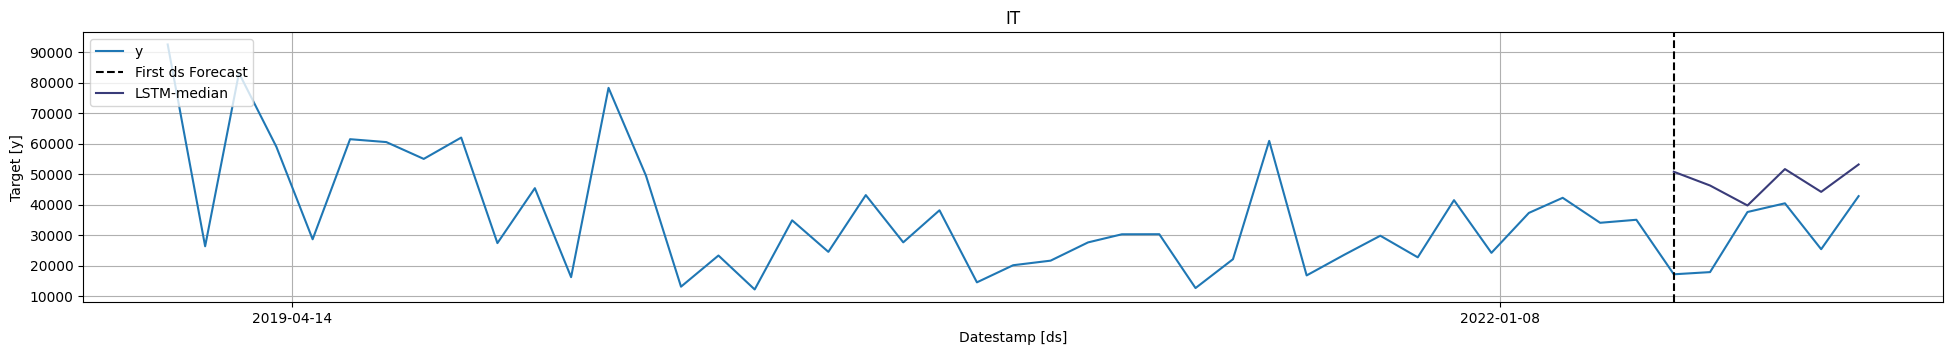

In [199]:
sf.plot(df_nixtla_new, y_hat_new, engine='matplotlib')

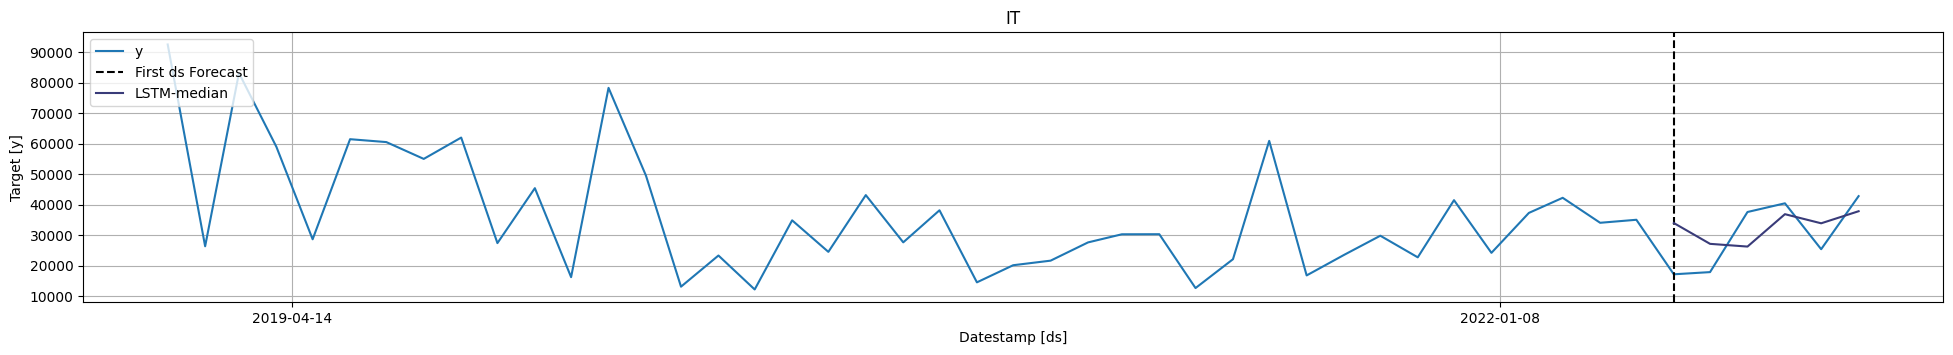

In [200]:
sf.plot(df_nixtla_new, y_hat_new2, engine='matplotlib')

In [206]:
gr_pred = y_hat_new.groupby('ds')[['LSTM-median', 'LSTM-lo-90', 'LSTM-hi-90']].sum().reset_index()
gr_true = df_nixtla_new[(df_nixtla_new.ds>'2022-05-01')].groupby('ds').y.sum().reset_index()

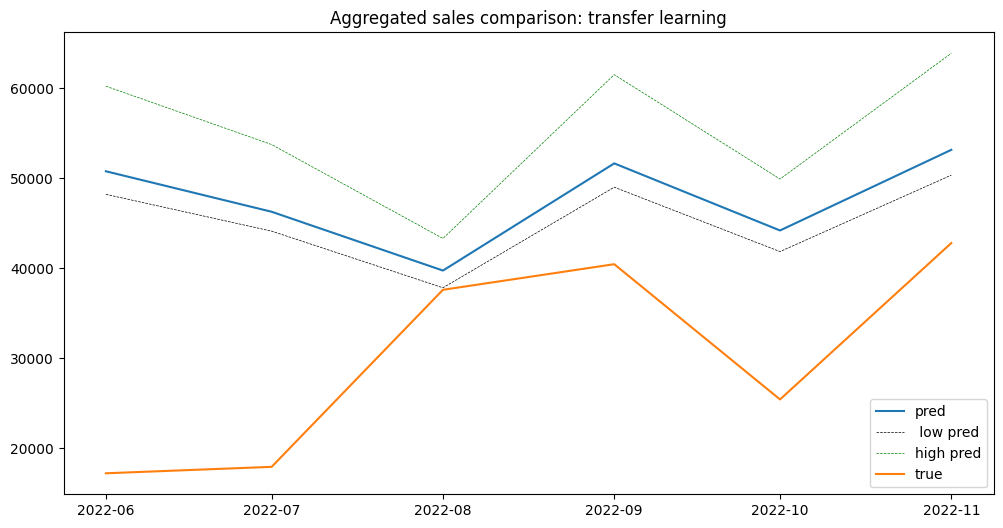

In [207]:
plt.figure(figsize=(12,6))
plt.plot(gr_pred.ds, gr_pred['LSTM-median'], label='pred')
plt.plot(gr_pred.ds, gr_pred['LSTM-lo-90'], ls='--', color='black', lw=.5, label=' low pred')
plt.plot(gr_pred.ds, gr_pred['LSTM-hi-90'], ls='--', color='green', lw=.5, label='high pred')
plt.plot(gr_true.ds, gr_true['y'], label='true')
plt.title('Aggregated sales comparison: transfer learning')
plt.legend()
plt.show()